### Implisitt Runge-Kutta midtpunktmetode

In [18]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import numpy.linalg as linalg
import sympy as sp

# pretty-print sympy things
sp.init_printing()

# nice big latex-flavored plots
# if you don't have these fonts, or you don't have
# XeLaTeX installed, this needs to be modified.
fontsize = 20
newparams = {
    'axes.titlesize': fontsize,
    'axes.labelsize': fontsize,
    'lines.linewidth': 2, 
    'lines.markersize': 7,
    'font.family': "serif",
    'text.usetex': True,
    "pgf.texsystem": "xelatex",
    "pgf.rcfonts": False,
    "pgf.preamble": [
        r"\usepackage{unicode-math}",
        r"\setmainfont{EB Garamond}",
        r"\setmonofont{Courier New}",
        r"\setmathfont[StylisticSet={2,7,10}]{Garamond-Math}",
    ],
    'figure.figsize': (16,9), 
    'ytick.labelsize': fontsize,
    'xtick.labelsize': fontsize,
    'legend.fontsize': fontsize,
    'legend.handlelength': 1.5,
    'xtick.major.pad': 8,
    'ytick.major.pad': 8,
}

bbox_settings = {
    'fc': 'w',
    'ec': 'k'
}

# !!!
# for some reason, on some machines, you need to run this cell twice
# it probably has something to do with python versions or something
# !!!
%matplotlib inline

# makes mpl use the pgf-renderer. sometimes (but not on all machines)
# this disables rendering in the notebook.
# if this happens on your machine, maybe use
# another backend while working, and switch
# to pgf when you want to generate the final plots.
# mpl.use('pgf')

# right angles never hurt anyone,
# so use classic as a base theme
plt.style.use('classic')
# the gray border is not visible in the plot rendered
# by plt.savefig, so dont't  worry about that

# finally change the necessary parameters
plt.rcParams.update(newparams)

In [5]:
def newton(F, JacFi, u0, tol=1e-6, maxiter=10):
    """ newtons method to sole non-linear systems
        with the iteration u <- u - inv(JacF) * F(u)
    parameters:
        F             The function to optimize.
        JacF          The Jacobian matrix of F.
        u0            The starting point.
    returns:
        u             The u s. t. F(u) = 0.
    """
    u = u0
    for _ in range(maxiter):
        u = u - np.dot(JacFi(u), F(u))
        
        if linalg.norm(F(u)) < tol:
            break

    return u

In [13]:
def RK(f, y0, t):
    """ implicit Runge-Kutta solver for y(t)
    parameters:
        f = f(t, y)
            The function we want to optimize.
            It must be compatible with sympy!
            
        y0  The initial y-vaule.
        ts  The array of t-values for which we want
            to approximate y(t) over.
        h   The step length.
    returns:
        ys  The array of approximate y-values y(t).
    """
    # create the system for u
    yn, tu, u = sp.symbols("y_n t_u u")
    F     = yn + f(tu, u) - u
    JacFi = 1 / sp.diff(F, u)
    
    # make it lambdas for the iteration
    F     = sp.lambdify((u, tu, yn), F)
    JacFi = sp.lambdify((u, tu, yn), JacFi)
 
    y = np.empty(t.shape)
    y[0] = y0
    for n in range(len(t) - 1):
        h = t[n + 1] - t[n]
        u = newton( # remove tu- and yn-dependence
            lambda u: F(u, t[n] + h/2, y[n]), 
            lambda u: JacFi(u, t[n] + h/2, y[n]),
            y[n]
        )
        y[n + 1] = y[n] + h * f(t[n] + h/2, u)
    return y

### Test med et enkelt 1-D problem

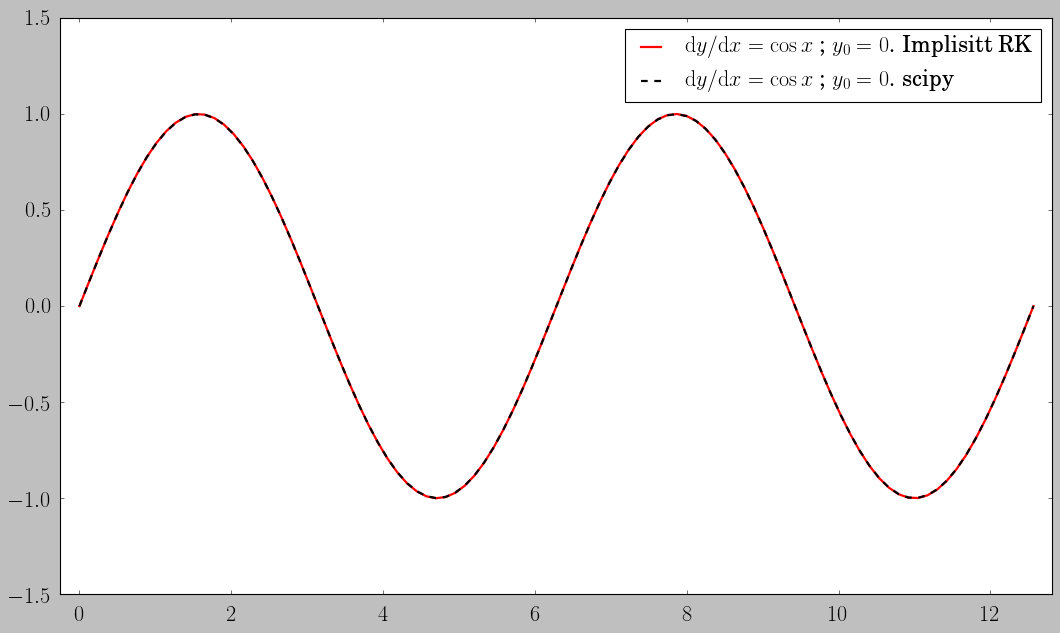

In [43]:
def f(t, y): return sp.cos(t)

ts = np.linspace(0, 4*np.pi, 100)

### our attempt
plt.plot(
    ts,
    rk(f, 0, t=ts),
    "r-",
    label="${\mathrm d y}/{\mathrm d x} = \cos x$ ; $y_0 = 0$. Implisitt RK",
)

### scipy "true" solution
import scipy.integrate as scp_int
plt.plot(
    ts,
    scp_int.odeint(f, y0 = 0, t=ts, tfirst=True),
    'k--',
    label='${\mathrm d y}/{\mathrm d x} = \cos x$ ; $y_0 = 0$. scipy'
)

plt.xlim(-0.25, 4*np.pi + 0.25)

plt.legend();